<a href="https://colab.research.google.com/github/hajaulee/HaJaULS/blob/master/correcting_rotation_of_documents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

In [69]:
!ls -ial '/content/drive/My Drive/correcting-rotation-of-documents/test_dataset'

total 156
15126 -rw------- 1 root root  45636 Mar 16 14:45 0-vi.jpg
15125 -rw------- 1 root root 113079 Mar 16 14:44 180-japan.jpg


In [13]:
import cv2 as cv
import glob
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.client import device_lib
from keras.layers import Convolution2D, Dropout, Dense, Flatten, MaxPooling2D, Input, BatchNormalization
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras import metrics
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [0]:
working_path = '/content/drive/My Drive/correcting-rotation-of-documents'
image_shape = (200,200,1)
nb_classes = 4

In [0]:
def indices_to_one_hot(data, nb_classes):
    """Convert an iterable of indices to one-hot encoded labels."""
    targets = np.array(data).reshape(-1)
    return np.eye(nb_classes)[targets]

In [0]:
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

In [0]:
def load_data(folder):
    X, labels, names = [],[], []
    list_images_file = glob.glob(os.path.join(folder, "*.jpg"))
    for filename in list_images_file:
        img = cv.imread(filename, cv.IMREAD_GRAYSCALE)
        img = cv.resize(img, image_shape[:2])
        img = np.asarray(img)
        img = img.reshape(image_shape)
        label = os.path.basename(filename)[0]
        X.append(img)
        labels.append(label)
        names.append(os.path.basename(filename))
#         print ('Loaded', filename)
    print("Loaded", len(list_images_file), 'files')
    return np.asarray(X), np.asarray(labels), names

In [0]:
def get_model(nb_classes):
    # size of pooling area for max pooling
    pool_size = (2, 2)
    # convolution kernel size
    kernel_size = (3,3)
    # convolution strides
    strides = (1,1)

    # model definition
    input = Input(shape=image_shape)
    x = Convolution2D(96, kernel_size,strides=strides,
                      activation='relu')(input)
    x = MaxPooling2D(pool_size=pool_size)(x)
    x = BatchNormalization()(x)
    x = Convolution2D(64, kernel_size, strides=strides,
                      activation='relu')(x)
    x = MaxPooling2D(pool_size=pool_size)(x)
    x = BatchNormalization()(x)
    x = Convolution2D(64, kernel_size, strides=strides,
                      activation='relu')(x)
    x = MaxPooling2D(pool_size=pool_size)(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.45)(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(rate=0.35)(x)
    x = Dense(nb_classes, activation='softmax')(x)

    model = Model(inputs=[input], outputs=x)

    model.summary()
    # model compilation
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [0]:
def train(model, train_, test_):
    # training parameters
    batch_size = 128
    nb_epoch = 50

    output_filename = 'model.json'
    # callbacks
    checkpointer = ModelCheckpoint(
        filepath=output_filename,
        save_best_only=True
    )
    early_stopping = EarlyStopping(patience=2)
    tensorboard = TensorBoard()


    # training loop
    with tf.device('/gpu:0'):
        histories = model.fit(train_[0], train_[1],
            epochs=nb_epoch,
            batch_size=125,
            validation_data=test_,
            verbose=True,
            shuffle=True,
            callbacks=[checkpointer, early_stopping, tensorboard]
        )

    return model, histories

In [51]:
start_time = time.time()
# Build model
model = get_model(nb_classes)
build_model_time = time.time() - start_time
    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 200, 200, 1)       0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 198, 198, 96)      960       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 99, 99, 96)        0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 99, 99, 96)        384       
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 97, 97, 64)        55360     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 48, 48, 64)        0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 48, 48, 64)        256       
__________

In [55]:
start_time = time.time()
images_path = os.path.join(working_path,'train_dataset')
print('Load images from', images_path)
X_data, Y_data, N_data = load_data(images_path)
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=.2, random_state=42)

load_data_time = time.time() - start_time
print('Training with', len(X_train), 'images and validate with', len(X_test), 'images') 

Load images from /content/drive/My Drive/correcting-rotation-of-documents/train_dataset
Loaded 2150 files
Training with 1720 images and validate with 430 images


In [0]:
labelencoder_X = LabelEncoder()
Y_train = labelencoder_X.fit_transform(Y_train)
Y_test = labelencoder_X.transform(Y_test)

Y_train = indices_to_one_hot(Y_train, nb_classes)
Y_test = indices_to_one_hot(Y_test, nb_classes)

In [57]:
start_time = time.time()
model, history = train(model, train_=(X_train, Y_train), test_=(X_test, Y_test))
train_model_time = time.time() - start_time
print("Training complete")

Train on 1720 samples, validate on 430 samples
Epoch 1/50
1720/1720 [==============================] - 12s 7ms/step - loss: 0.5043 - acc: 0.9477 - val_loss: 3.6701 - val_acc: 0.7023
Epoch 2/50
1720/1720 [==============================] - 9s 5ms/step - loss: 0.2693 - acc: 0.9698 - val_loss: 5.5515 - val_acc: 0.5744
Epoch 3/50
1720/1720 [==============================] - 9s 5ms/step - loss: 0.2033 - acc: 0.9773 - val_loss: 2.1835 - val_acc: 0.7651
Epoch 4/50
1720/1720 [==============================] - 9s 5ms/step - loss: 0.1775 - acc: 0.9808 - val_loss: 1.8154 - val_acc: 0.8326
Epoch 5/50
1720/1720 [==============================] - 9s 5ms/step - loss: 0.1684 - acc: 0.9826 - val_loss: 1.2213 - val_acc: 0.8581
Epoch 6/50
1720/1720 [==============================] - 9s 5ms/step - loss: 0.1479 - acc: 0.9820 - val_loss: 0.5469 - val_acc: 0.8814
Epoch 7/50
1720/1720 [==============================] - 9s 5ms/step - loss: 0.1458 - acc: 0.9860 - val_loss: 0.3032 - val_acc: 0.9419
Epoch 8/50
172

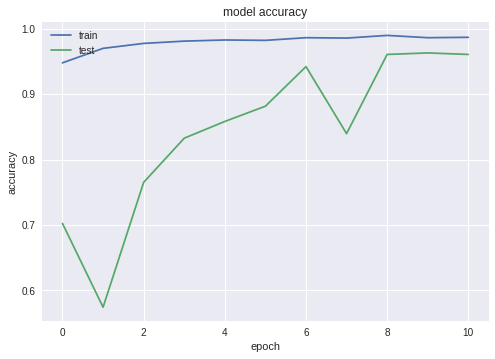

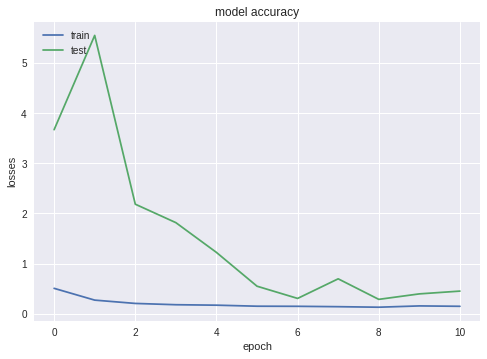

430/430 [==============================] - 1s 3ms/step
Evaluate model: loss:0.4492380818406345, acc:0.960465115447377
Build model in 0.5042169094085693 seconds.
Load data in 55.47344708442688 seconds.
Train model in 104.97496175765991 second.


In [58]:
# summarize history for accuracy
plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('losses')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
test_loss, test_acc = model.evaluate(X_test, Y_test)
print("Evaluate model: loss:{}, acc:{}".format(test_loss, test_acc))
print("Build model in {} seconds.".format(build_model_time))
print("Load data in {} seconds.".format(load_data_time))
print("Train model in {} second.".format(train_model_time))

In [84]:
print("Label:",Y_test[1])
tmp_test = np.expand_dims(X_test[1], axis=0)
print("Predict:",model.predict(tmp_test))

real_data = load_data(os.path.join(working_path,'test_dataset'))

real_labels = indices_to_one_hot(labelencoder_X.transform(real_data[1]), nb_classes)

print(np.expand_dims(np.asarray(real_data[2]), axis=1))
print("Real data label:\n", real_labels)
predicted_result = model.predict(real_data[0])
hot_results = []

for row in predicted_result:
    hot_index = np.where(row == max(row))[0][0]
    hot_result = [0] * len(row)
    hot_result[hot_index] = 1
    hot_results.append(hot_result)
hot_results = np.asarray(hot_results)
print("Real data Predict:\n", hot_results)

real_test_loss, real_test_acc = model.evaluate(real_data[0], real_labels)
print("Evaluate model: loss:{}, acc:{}".format(real_test_loss, real_test_acc))

Label: [0. 1. 0. 0.]
Predict: [[0. 1. 0. 0.]]
Loaded 10 files
[['0-vi.jpg']
 ['180-japan.jpg']
 ['90-viet-tay.jpg']
 ['270-viet-tay.jpg']
 ['270-the-cu-chi.jpg']
 ['90-the-cu-chi.jpg']
 ['180-viet-tay.jpg']
 ['0-the-cu-chi.jpg']
 ['180-the-cu-chi.jpg']
 ['0-viet-tay.jpg']]
Real data label:
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]
Real data Predict:
 [[1 0 0 0]
 [0 1 0 0]
 [1 0 0 0]
 [0 0 0 1]
 [1 0 0 0]
 [0 0 0 1]
 [0 0 0 1]
 [1 0 0 0]
 [0 0 0 1]
 [1 0 0 0]]
10/10 [==============================] - 0s 3ms/step
Evaluate model: loss:3.70605731010437, acc:0.5
